# Introduction
We will fit a regression model of time $t$ industry returns on lagged industry returns using XGBoost. This model can then predict future returns, which we will use as our investment signal. We chose to use lagged returns of lengths 1, 2, 3, 6, 9, 12, and 15 months. The XGBoost regressor is fit using data from time $t - 48$ to $t - 1$. Since XGBoost often produces draws, we used a score weighted investment strategy; we demeaned the predicted values and then normalized the results so the long- and short-position time $t$ weights added to $1$ and $-1$, respectively. The data were obtained from the Ken French Data Library. We used equally weighted monthly industry returns. The date range is from July 1927 to December 2020.

# Packages and Setup

In [492]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import datetime as dt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
os.chdir('/Users/charlesrambo/Desktop/GitHub data')


In [493]:
# Load equally weighted industry return data
industry = pd.read_csv('10_Industry_Portfolios.csv')

# Convert date column into date-time object
industry['Date'] = pd.to_datetime(industry['Date'], format = '%Y%m') + MonthEnd(0)

# Convert returns to a decimal 
industry.iloc[:, 1:] = industry.iloc[:, 1:].div(100)

# Save industry names
cols = np.sort(industry.columns[1:])

# Add the date to the list for later use
cols = np.insert(cols, 0, 'Date')

# Convert rows into columns
industry = pd.melt(industry, id_vars = ['Date'], value_vars = industry.columns[1:])

# Rename columns
industry.columns = ['Date', 'Industry', 'Ret']

industry.head()

,Date,Industry,Ret
0,1926-07-31,NoDur,0.0116
1,1926-08-31,NoDur,0.0500
2,1926-09-30,NoDur,0.0003
3,1926-10-31,NoDur,-0.0255
4,1926-11-30,NoDur,0.0600


In [494]:
# List the return lags which we will use
lags = [1, 2, 3, 6, 9, 12, 15]

# Sort industry data frame by industry column and then by date
industry.sort_values(['Industry', 'Date'], axis = 0, inplace = True)

# For each lag in our list, group by industry and shift by the lag
for lag in lags:
    industry['Ret_lag' + str(lag)] = industry.groupby('Industry')['Ret'].transform(lambda x: x.shift(lag))
    
# Drop missing rows
industry.dropna(axis = 0, inplace = True)

industry.head()

,Date,Industry,Ret,Ret_lag1,Ret_lag2,Ret_lag3,Ret_lag6,Ret_lag9,Ret_lag12,Ret_lag15
1149,1927-10-31,Durbl,-0.0369,-0.0077,0.0174,0.0621,-0.0117,-0.0227,-0.0946,0.0403
1150,1927-11-30,Durbl,0.1138,-0.0369,-0.0077,0.0174,0.0415,0.0606,-0.0038,0.0028
1151,1927-12-31,Durbl,0.0659,0.1138,-0.0369,-0.0077,-0.0397,-0.0236,0.0480,-0.0334
1152,1928-01-31,Durbl,-0.0194,0.0659,0.1138,-0.0369,0.0621,-0.0117,-0.0227,-0.0946
1153,1928-02-29,Durbl,-0.0245,-0.0194,0.0659,0.1138,0.0174,0.0415,0.0606,-0.0038


In [495]:
# Sort by date then industry column
industry.sort_values(['Date', 'Industry'], axis = 0, inplace = True)

# Define the xgb window
xgb_window = 48

# This data will be used for grid search
pre_train = industry.loc[industry['Date'].dt.year <= 1980, :].reset_index(drop = True)

# Create training set
good_obs = (industry['Date'] >= pre_train['Date'].max() - MonthEnd(xgb_window - 1)) & (industry['Date'].dt.year <= 2005) 
train = industry.loc[good_obs, :].reset_index(drop = True)

# Create training set
test =  industry.loc[industry['Date'] >= train['Date'].max() - MonthEnd(xgb_window - 1), :].reset_index(drop = True)

del industry

pre_train.head()

,Date,Industry,Ret,Ret_lag1,Ret_lag2,Ret_lag3,Ret_lag6,Ret_lag9,Ret_lag12,Ret_lag15
0,1927-10-31,Durbl,-0.0369,-0.0077,0.0174,0.0621,-0.0117,-0.0227,-0.0946,0.0403
1,1927-10-31,Enrgy,-0.0450,0.0397,-0.0196,0.0220,-0.0393,0.0368,0.0267,-0.0219
2,1927-10-31,HiTec,-0.0383,0.0428,-0.0161,0.0744,0.0204,0.0044,-0.0572,0.0221
3,1927-10-31,Hlth,0.0515,0.0600,0.0015,0.0859,0.0580,0.0613,0.0013,0.0245
4,1927-10-31,Manuf,-0.0463,0.0142,0.0073,0.0782,0.0157,0.0078,-0.0511,0.0230


In [496]:
# Parameters to optimize using grid search
params = {'colsample_bytree': [0.01, 0.05, 0.09], 'max_depth': [1, 2, 3], 'n_estimators': [16, 17, 18]}

# Initialize model
model = xgb.XGBRegressor()

# Perform grid search based on MSE; five-fold cross-validation
grid_search = GridSearchCV(param_grid = params, estimator = model, scoring = 'neg_mean_squared_error', 
                        cv = 5, verbose = 0)

# Get explanatory and response variables
X = pre_train.iloc[:, 3:].values
y = pre_train.iloc[:, 2].values
    
# Fit grid_search to the data
grid_search.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_search.best_params_)

# Delete data that has done their jobs; we will copy the parameters into the function manually
del X, y, pre_train, grid_search


Best parameters found:  {'colsample_bytree': 0.01, 'max_depth': 2, 'n_estimators': 17}


# Training Set Results

In [509]:
# Create function to calculate signal
def calc_xgb_sig(data, window):

    # Get unique dates
    dates = np.unique(data['Date'])[window:]

    # Create data frame to record signal values
    xgb_sig = pd.DataFrame(index = range(len(dates)), columns = cols)

    for date in dates:
    
        # Obtain the end of the signal formation; this value is excluded
        stop = np.sum(data['Date'] < date)
    
        # Record the beginning of signal, inclusive
        start = np.sum(data['Date'] + dt.timedelta(days = 7) + MonthEnd(window) < date)
    
        # Get 'measurement' values for Kalman filter
        X = data.iloc[start:stop, 3:].values
        y = data.iloc[start:stop, 2].values
        
        # Instantiate model
        model = xgb.XGBRegressor(colsample_bytree = 0.01, max_depth = 2, n_estimators = 17)
    
        # Fit model
        model.fit(X, y)
    
        # Record date for later merger
        xgb_sig.loc[stop, 'Date'] = date 
        xgb_sig.loc[stop, 1:] = model.predict(data.loc[data['Date'] == date, data.columns[3:]].values)
    
    # Convert data column to data-time object
    xgb_sig['Date'] = pd.to_datetime(xgb_sig['Date'])
    
    # Drop missing values
    xgb_sig.dropna(axis = 0, inplace = True)
    
    # Depivot xgb_sig
    xgb_sig = pd.melt(xgb_sig, id_vars = ['Date'], value_vars = xgb_sig.columns[1:])
    
    # Rename columns
    xgb_sig.columns = ['Date', 'Industry', 'Signal']
    
    # Convert signal to float
    xgb_sig['Signal'] = xgb_sig['Signal'].astype('float')
     
    return xgb_sig

# Calculate the signal
xgb_sig_train = calc_xgb_sig(train, xgb_window)

xgb_sig_train.head()

,Date,Industry,Signal
0,1981-01-31,Durbl,0.027080
1,1981-02-28,Durbl,0.019887
2,1981-03-31,Durbl,-0.041195
3,1981-04-30,Durbl,0.038746
4,1981-05-31,Durbl,0.027466


In [510]:
# Create function that combines returns with signal and then implements strategy
def calc_strg_rtn(returns, signal):
       
    # Calculate percentile
    signal['wt'] = signal['Signal'] - signal.groupby('Date')['Signal'].transform('mean')
     
    # Drop signal
    signal.drop('Signal', axis = 1, inplace = True)
    
    # Long-end sums to 1
    signal.loc[signal['wt'] >= 0, 'wt'] = signal.loc[signal['wt'] >= 0, 'wt']/signal.loc[signal['wt'] >= 0, :].groupby('Date')['wt'].transform('sum')
    
    # Short-end sums to -1.
    signal.loc[signal['wt'] < 0, 'wt'] = -signal.loc[signal['wt'] < 0, 'wt']/signal.loc[signal['wt'] < 0, :].groupby('Date')['wt'].transform('sum')
         
    # Perform merge
    df = returns.merge(signal, on = ['Date', 'Industry'])

    # Drop columns that have done their jobs
    df.drop('Industry', axis = 1, inplace = True)
    
    # Calculate weighted returns
    df['Ret'] = df['wt'] * df['Ret']
    
    # Calculate equally weighted return of strategy at each date
    result = df.groupby('Date')['Ret'].sum().reset_index()
    
    return result

# Create data frame for returns
result_train = calc_strg_rtn(returns = train, signal = xgb_sig_train)

result_train.head()

,Date,Ret
0,1981-01-31,-0.078623
1,1981-02-28,-0.016035
2,1981-03-31,-0.041965
3,1981-04-30,0.108463
4,1981-05-31,-0.008838


In [511]:
# Create function which gives return statistics
def get_rtn_stats(result):
    
    # Create data frame for return statistics
    stats = pd.DataFrame(index = result.columns[1:])

    # Take a look at the mean
    stats['mean'] = 12 * result.mean()

    # Take a look at the sd
    stats['sd'] = 12**(1/2) * result.std()

    # Take a look at the skew
    stats['skew'] = 12**(3/2) * result.skew()

    return stats

# Obtain return statistics for training set
get_rtn_stats(result_train)

,mean,sd,skew
Ret,0.10984,0.16179,-17.319358


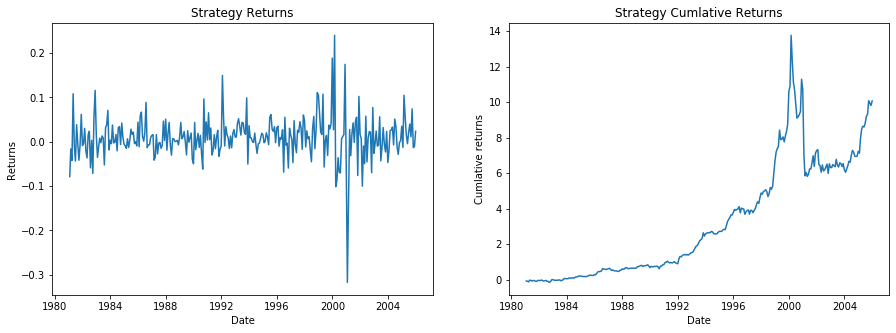

In [512]:
# Create function to plot results
def plot_result(result):

    # Plot returns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

    ax1.plot(result['Date'], result['Ret'])
    ax1.set_xlabel('Date') 
    ax1.set_ylabel('Returns') 
    ax1.set_title('Strategy Returns') 

    ax2.plot(result['Date'], (1 + result['Ret']).cumprod() - 1) 
    ax2.set_xlabel('Date') 
    ax2.set_ylabel('Cumlative returns') 
    ax2.set_title('Strategy Cumlative Returns') 

    plt.show()
    
plot_result(result_train)

# Testing Set Results

In [513]:
# Calculate the signal
xgb_sig_test = calc_xgb_sig(test, xgb_window)

xgb_sig_test.head()

,Date,Industry,Signal
0,2006-01-31,Durbl,0.008830
1,2006-02-28,Durbl,-0.004777
2,2006-03-31,Durbl,0.012881
3,2006-04-30,Durbl,0.010003
4,2006-05-31,Durbl,0.032774


In [514]:
# Create data frame for returns
result_test = calc_strg_rtn(returns = test, signal = xgb_sig_test)

result_test.head()

,Date,Ret
0,2006-01-31,0.032141
1,2006-02-28,-0.045519
2,2006-03-31,0.009833
3,2006-04-30,-0.004528
4,2006-05-31,0.031341


In [515]:
get_rtn_stats(result_test)

,mean,sd,skew
Ret,-0.066816,0.175741,-44.888337


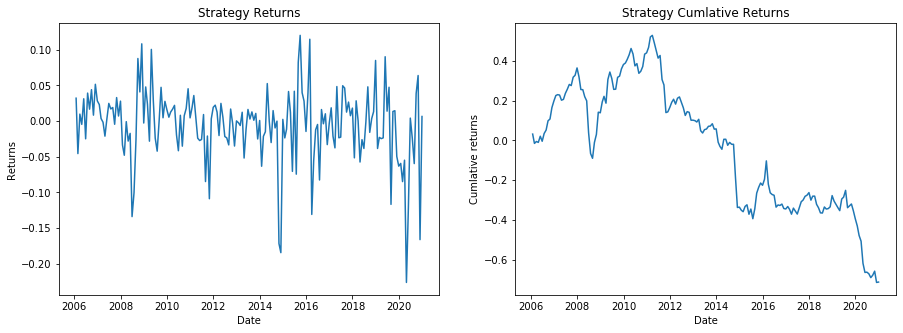

In [516]:
plot_result(result_test)